In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import ase.io
from time import time
from copy import deepcopy

from aml_storage import Labels, Block, Descriptor

from utils.librascal import RascalSphericalExpansion
from utils.clebsh_gordan import ClebschGordanReal

from utils.acdc import *

This example demonstrates the iterative construction of atom-centered density correlations.
The calculations incorporate ideas from the N-body iterative contraction of equivariants [paper](https://doi.org/10.1063/5.0021116) and the optimal radial basis [paper](https://doi.org/10.1063/5.0057229).

# Covariance-optimal basis

We start by computing the spherical expansion representation for a set of methane structures. 

In [2]:
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 3,
    "max_angular": 2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

nmax, lmax = rascal_hypers["max_radial"], rascal_hypers["max_angular"]
calculator = RascalSphericalExpansion(rascal_hypers)

In [3]:
frames = ase.io.read("./data/random-methane-10k.extxyz", "::100")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [4]:
density_expansion = calculator.compute(frames)

Then, select the C,H block, which is the most significant for this dataset, and project to the optimal covariance basis.

In [5]:
# for each (C,H) block, construct the optimal covariance basis
opt_eve = {}
opt_eva = {}
full_norms = np.zeros(len(frames))
for index, block in density_expansion:
    if index["center_species"] == 6 and index["neighbor_species"] == 1:
        feats = block.values.reshape(-1, len(block.features))
        full_norms += (block.values**2).sum(axis=-1).sum(axis=-1)
        cov = feats.T @ feats / feats.shape[0]
        eva, eve = sp.linalg.eigh(cov)
        eva = eva[::-1]; eve = eve[:,::-1]
        opt_eva[index["spherical_harmonics_l"]] = eva
        opt_eve[index["spherical_harmonics_l"]] = eve

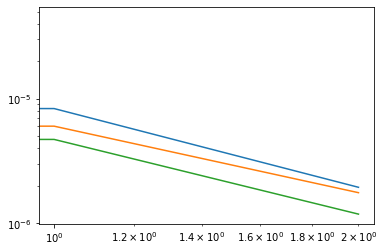

In [6]:
for l in range(lmax+1):
    plt.loglog(opt_eva[l])

Create compressed features, using labels naming consistent with Nigam 2020

In [7]:
sel_thresh = 1.5e-6
blocks = []
for l in range(lmax+1):
    n_selected = len(np.where(opt_eva[l] > sel_thresh)[0])    
    de_block = density_expansion.block(center_species = 6, neighbor_species=1, spherical_harmonics_l = l)
    block = Block(
        values = de_block.values@opt_eve[l][:,:n_selected],
        samples = de_block.samples,
        components = Labels(["m"],np.asarray(range(-l,l+1), dtype=np.int32).reshape(-1,1)),
        features = Labels(["n"], np.asarray([[n] for n in range(n_selected)], dtype=np.int32))
    )
    if rascal_hypers["compute_gradients"]:
        de_grad = de_block.gradient("positions")
        block.add_gradient(
            name="positions",
            samples=de_grad[0],
            gradient=de_grad[1]@opt_eve[l][:,:n_selected],
        )
    blocks.append( block )

In [8]:
acdc_nu1 = Descriptor(sparse = Labels(names=["sigma", "lam", "nu"], 
                                      values=np.asarray([[ 1, l, 1] for l in range(rascal_hypers["max_angular"]+1)], dtype=np.int32)), 
                      blocks = blocks
                     )

In [9]:
# multiplicity of the features, stored as a descriptor array
acdc_full_nu1 = Descriptor(
    sparse = acdc_nu1.sparse,
    blocks = [
        Block(
            values = np.ones(shape=(1,1,len(acdc_nu1.block(s).features))),
            samples = Labels(["dummy"], np.zeros(shape=(1,1), dtype=np.int32)),
            components = Labels(["dummy"], np.zeros(shape=(1,1), dtype=np.int32)),
            features = acdc_nu1.block(s).features
        ) for s in acdc_nu1.sparse
    ]
)

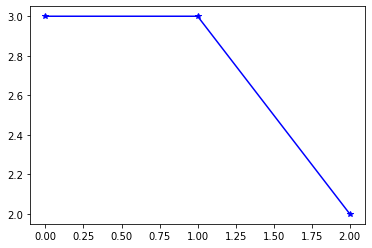

In [10]:
ln_nu1 = np.asarray([[s["lam"], b.values.shape[-1]] for s,b in acdc_nu1 ])
plt.plot(ln_nu1[:,0], ln_nu1[:,1], 'b*-')

# ACDC utilities

In [11]:
cg = ClebschGordanReal(lmax*3)

default (all to all)

In [12]:
acdc_nu2 = cg_increment(acdc_nu1, acdc_nu1, clebsch_gordan=cg)

specifying features

In [13]:
%%time
acdc_nu2 = cg_increment(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, clebsch_gordan=cg)
acdc_full_nu2 = full_product_indices(acdc_full_nu1, acdc_full_nu1)

CPU times: user 31.9 ms, sys: 2.86 ms, total: 34.7 ms
Wall time: 33.8 ms


In [14]:
%%time
acdc_nu3 = cg_increment(acdc_nu2, acdc_nu1, acdc_full_nu2, acdc_full_nu1, clebsch_gordan = cg)

CPU times: user 190 ms, sys: 10.3 ms, total: 200 ms
Wall time: 199 ms


## analyze jacobian

Requires `compute_gradients=True`

manually densify features

In [ ]:
j_nu1 = []
for idx, block in acdc_nu1:
    smp, grad = block.gradient("positions")
    j_nu1.append(grad.reshape((grad.shape[0],-1)))
j_nu1 = np.concatenate(j_nu1, axis=-1).reshape(10,12,-1)    

In [ ]:
j_nu2 = []
for idx, block in acdc_nu2:
    smp, grad = block.gradient("positions")
    j_nu2.append(grad.reshape((grad.shape[0],-1)))
j_nu2 = np.concatenate(j_nu2, axis=-1).reshape(10,12,-1)

In [ ]:
j_nu3 = []
for idx, block in acdc_nu3:
    smp, grad = block.gradient("positions")
    j_nu3.append(grad.reshape((grad.shape[0],-1)))
j_nu3 = np.concatenate(j_nu3, axis=-1).reshape(10,12,-1)

sv_nu3 = np.asarray([ sp.linalg.svdvals(j_nu3[i])  for i in range(10)])

In [ ]:
import scipy as sp

In [ ]:
sv_nu1 = np.asarray([ sp.linalg.svdvals(j_nu1[i])  for i in range(10)])
sv_nu2 = np.asarray([ sp.linalg.svdvals(j_nu2[i])  for i in range(10)])

In [ ]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu2[:,0]/sv_nu2[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=2)$")

In [ ]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu3[:,0]/sv_nu3[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=3)$")

# Independent feature tracking

This performs the cg iteration while avoiding to compute duplicate / linearly dependent features, and tracks the multiplicity so that no density (correlation) is lost

In [15]:
cg = ClebschGordanReal(lmax*5)

In [16]:
norm_full1 = features_norm(acdc_nu1)

In [17]:
acdc_sel_nu2 = canonical_indices(acdc_full_nu1, acdc_full_nu1)

In [18]:
%%time
canonical_acdc_nu2 = cg_increment(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, clebsch_gordan=cg, M=acdc_sel_nu2)

CPU times: user 38.4 ms, sys: 1.6 ms, total: 40 ms
Wall time: 48.3 ms


In [19]:
acdc_sel_nu3 = canonical_indices(acdc_sel_nu2, acdc_full_nu1)

In [20]:
%%time
canonical_acdc_nu3 = cg_increment(canonical_acdc_nu2, acdc_nu1, acdc_sel_nu2, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu3)

CPU times: user 167 ms, sys: 4.73 ms, total: 172 ms
Wall time: 171 ms


In [21]:
acdc_sel_nu4 = canonical_indices(acdc_sel_nu3, acdc_full_nu1)

In [22]:
%%time
canonical_acdc_nu4 = cg_increment(canonical_acdc_nu3, acdc_nu1, acdc_sel_nu3, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu4)

CPU times: user 1.07 s, sys: 22.8 ms, total: 1.09 s
Wall time: 1.09 s


In [23]:
acdc_sel_nu5 = canonical_indices(acdc_sel_nu4, acdc_full_nu1)

In [24]:
%%time
canonical_acdc_nu5 = cg_increment(canonical_acdc_nu4, acdc_nu1, acdc_sel_nu4, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu5)

CPU times: user 8.16 s, sys: 189 ms, total: 8.35 s
Wall time: 8.45 s


compute norms and show that they match the norm of nu=1 features to the power nu

In [27]:
nnu2_full = features_count(acdc_nu2)
nnu2_can = features_count(canonical_acdc_nu2)
norm_full2 = features_norm(acdc_nu2)
norm_can2 = features_norm(canonical_acdc_nu2)

In [28]:
print((nnu2_full, norm_full2.sum()), (nnu2_can, norm_can2.sum()), (norm_full1**2).sum())

(122, 3.873834622434605e-06) (72, 3.873834622434605e-06) 3.8738346224346055e-06


In [29]:
nnu3_full = features_count(acdc_nu3)
nnu3_can = features_count(canonical_acdc_nu3)
norm_full3 = features_norm(acdc_nu3)
norm_can3 = features_norm(canonical_acdc_nu3)

In [30]:
print((nnu3_full, norm_full3.sum()), (nnu3_can, norm_can3.sum()),(norm_full1**3).sum())

(2204, 9.607837605262187e-10) (564, 9.60783760526219e-10) 9.607837605262195e-10


In [31]:
nnu4_can = features_count(canonical_acdc_nu4)
norm_can4 = features_norm(canonical_acdc_nu4)

In [32]:
print((nnu4_can, norm_can4.sum()),(norm_full1**4).sum())

(4020, 2.674918841614878e-13) 2.6749188416148813e-13


In [33]:
nnu5_can = features_count(canonical_acdc_nu5)
norm_can5 = features_norm(canonical_acdc_nu5)

In [34]:
print((nnu5_can, norm_can5.sum()),(norm_full1**5).sum())

(26568, 8.126066561228682e-17) 8.126066561228693e-17


# Iterative scheme

In [ ]:
acdc_thresh_nu2, thrnorm_nu2 = threshold_indices(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, 
                                                      sel_threshold=1e-9, l_threshold=6)

In [ ]:
acdc_thresh_nu2, thrnorm_nu2 = threshold_indices(acdc_nu1, acdc_nu1, sel_threshold=1e-9, l_threshold=6)

In [ ]:
acdc_thr_nu2 = cg_increment(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, M=acdc_thresh_nu2, clebsch_gordan=cg)

In [ ]:
norm_thr2 = features_norm(acdc_thr_nu2)
nnu2_thr = features_count(acdc_thr_nu2)

In [ ]:
print( norm_thr2.mean(), norm_thr2.mean()+thrnorm_nu2, norm_full2.mean())

In [ ]:
print(nnu2_full, nnu2_can, nnu2_thr)

In [ ]:
acdc_zip_nu2, acdc_w_nu2 = compress_features(acdc_thr_nu2, 1e-9)

In [ ]:
norm_zip2 = features_norm(acdc_zip_nu2)
nnu2_zip = features_count(acdc_zip_nu2)

In [ ]:
print(norm_zip2.mean(), norm_thr2.mean(), norm_full2.mean())
print(nnu2_full, nnu2_can, nnu2_thr, nnu2_zip)

## zipo New heading

recompute the compressed features!

In [ ]:
acdc_zip_post_nu2 = cg_increment(acdc_nu1, acdc_nu1,  M=acdc_w_nu2, clebsch_gordan=cg)

In [ ]:
features_norm(acdc_zip_post_nu2).mean()

In [ ]:
features_norm(acdc_zip_nu2).mean()

In [ ]:
acdc_thresh_nu3, thrnorm_nu3 = threshold_indices(acdc_zip_nu2, acdc_nu1, sel_threshold=1e-15, l_threshold=6)

In [ ]:
acdc_nu1.block(1).values.shape

In [ ]:
acdc_zip_nu2.block(1).values.shape

In [ ]:
acdc_full_nu1.block(0).values.shape

In [ ]:
features = acdc_full_nu2.block(0).features

In [ ]:
(0,0,0,0) in acdc_full_nu2.block(0).features

In [ ]:
acdc_full_nu2.sparse

In [ ]:
np.int32((0,0,0,0))in  features

In [ ]:
acdc_thr_nu3 = cg_increment(acdc_zip_nu2, acdc_nu1, M=acdc_thresh_nu3)